In [1]:
# Import necessary libraries and packages
import math
import numpy as np
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

from qiskit import Aer, IBMQ, QuantumCircuit
from qiskit.primitives import Estimator
from qiskit.utils import QuantumInstance
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.opflow import PauliSumOp, commutator, CircuitStateFn
from qiskit.opflow.converters import AbelianGrouper
from qiskit.compiler import transpile

# Import Qiskit libraries for VQE
# from qiskit.algorithms import NumPyMinimumEigensolver, VQE
# from qiskit.algorithms.optimizers import SLSQP, SPSA, COBYLA

# Import Qiskit Nature libraries
# from qiskit_nature.algorithms import GroundStateEigensolver, VQEUCCFactory
# from qiskit_nature.circuit.library import UCC, UCCSD
# from qiskit_nature.drivers import Molecule
# from qiskit_nature.drivers.second_quantization import (ElectronicStructureDriverType,
#                                                        ElectronicStructureMoleculeDriver)
# from qiskit_nature.converters.second_quantization import QubitConverter
# from qiskit_nature.mappers.second_quantization import BravyiKitaevMapper, JordanWignerMapper, ParityMapper
# from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
# from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer

# from qiskit_nature.settings import settings
# settings.dict_aux_operators = True

In [2]:
import numpy as np

In [3]:
from numpy.math import factorial

ModuleNotFoundError: No module named 'numpy.math'

In [4]:
def calc(n, k):
    summation = 0
    for i in range(1, k + 1):
        summation += np.math.factorial(n)/(np.math.factorial(i)*np.math.factorial(n-i))
    exp = np.power(2, n)
    return summation, exp

In [5]:
length = 8
nchoosek, exp = calc(length,int(length*0.25))
print(nchoosek, exp, 2*nchoosek/exp)

36.0 256 0.28125


In [6]:
length = 8
nchoosek, exp = calc(length,int(length*0.25))
print(nchoosek, exp, 2*nchoosek/exp)

36.0 256 0.28125


First we test the active space to identify the proper orbitals to include.

In [7]:
# active space test

def get_qubit_op_1(dist):
    
    theta = (180 - 107.6)/2*np.pi/180
    h2o = [["O", [0.0, 0.0, 0.0]], 
           ["H", [dist*np.cos(theta), -dist*np.sin(theta), 0.0]], 
           ["H", [-dist*np.cos(theta), -dist*np.sin(theta), 0.0]]]
    
    water = Molecule(geometry=h2o, multiplicity=1, charge=0)
    driver = ElectronicStructureMoleculeDriver(water,
                                               basis="6-31g",
                                               driver_type=ElectronicStructureDriverType.PYSCF) 
    
    transformer = ActiveSpaceTransformer(num_electrons=(2,2),
                                         num_molecular_orbitals=4,
                                         active_orbitals=[2,3,5,6])
    
    problem = ElectronicStructureProblem(driver, [transformer])
    
    # generate the second-quantized operators
    second_q_ops = problem.second_q_ops()
    converter = QubitConverter(mapper=JordanWignerMapper())
    # map to qubit operators
    qubit_op = converter.convert(second_q_ops.get('ElectronicEnergy'), num_particles=problem.num_particles)
    
    return qubit_op, converter, problem



def get_qubit_op_2(dist):
    
    theta = (180 - 107.6)/2*np.pi/180
    h2o = [["O", [0.0, 0.0, 0.0]], 
           ["H", [dist*np.cos(theta), -dist*np.sin(theta), 0.0]], 
           ["H", [-dist*np.cos(theta), -dist*np.sin(theta), 0.0]]]
    
    water = Molecule(geometry=h2o, multiplicity=1, charge=0)
    driver = ElectronicStructureMoleculeDriver(water,
                                               basis="6-31g",
                                               driver_type=ElectronicStructureDriverType.PYSCF) 
    
    transformer = ActiveSpaceTransformer(num_electrons=(2,2),
                                         num_molecular_orbitals=4,
                                         active_orbitals=[3,4,5,6])
    
    problem = ElectronicStructureProblem(driver, [transformer])
    
    # generate the second-quantized operators
    second_q_ops = problem.second_q_ops()
    converter = QubitConverter(mapper=JordanWignerMapper())
    # map to qubit operators
    qubit_op = converter.convert(second_q_ops.get('ElectronicEnergy'), num_particles=problem.num_particles)
    
    return qubit_op, converter, problem



def get_qubit_op_3(dist):
    
    theta = (180 - 107.6)/2*np.pi/180
    h2o = [["O", [0.0, 0.0, 0.0]], 
           ["H", [dist*np.cos(theta), -dist*np.sin(theta), 0.0]], 
           ["H", [-dist*np.cos(theta), -dist*np.sin(theta), 0.0]]]
    
    water = Molecule(geometry=h2o, multiplicity=1, charge=0)
    driver = ElectronicStructureMoleculeDriver(water,
                                               basis="6-31g",
                                               driver_type=ElectronicStructureDriverType.PYSCF) 
    
    transformer = ActiveSpaceTransformer(num_electrons=(2,2),
                                         num_molecular_orbitals=4,
                                         active_orbitals=[2,4,5,6])
    
    problem = ElectronicStructureProblem(driver, [transformer])
    
    # generate the second-quantized operators
    second_q_ops = problem.second_q_ops()
    converter = QubitConverter(mapper=JordanWignerMapper())
    # map to qubit operators
    qubit_op = converter.convert(second_q_ops.get('ElectronicEnergy'), num_particles=problem.num_particles)
    
    return qubit_op, converter, problem

In [8]:
distances = np.arange(0.7, 2.9, 0.055)
optimizer = COBYLA()

FCI_1 = []
FCI_2 = []
FCI_3 = []

for dist in tqdm(distances):
    
    for i in range(1,4):
        globals()['qubit_op_%d' % i], converter, problem = globals()['get_qubit_op_%d' % i](dist)
        numpy_solver = NumPyMinimumEigensolver()
        calc = GroundStateEigensolver(converter, numpy_solver)
        res = calc.solve(problem)
        globals()['FCI_%d' % i].append(np.real(res.total_energies))

NameError: name 'COBYLA' is not defined

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4), dpi=200)
plt.plot(distances, FCI_1, label='[2,3,5,6]', linewidth=2, color='tab:blue')
plt.plot(distances, FCI_2, label='[3,4,5,6]', linewidth=2, color='tab:orange')
plt.plot(distances, FCI_3, label='[2,4,5,6]', linewidth=2, color='tab:green')
plt.xlabel('Atomic distance (Angstrom)', fontsize=16)
plt.ylabel('Energy [Ha]', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(labelsize=16)
plt.title(r'Potential Energy Surface of $H_2 O$', fontsize=16)
plt.legend(fontsize=16, loc='best', edgecolor='black')
plt.show()

NameError: name 'FCI_1' is not defined

<Figure size 1200x800 with 0 Axes>

In [10]:
def get_qubit_op(dist):
    
    theta = (180 - 107.6)/2*np.pi/180
    h2o = [["O", [0.0, 0.0, 0.0]], 
           ["H", [dist*np.cos(theta), -dist*np.sin(theta), 0.0]], 
           ["H", [-dist*np.cos(theta), -dist*np.sin(theta), 0.0]]]
    
    water = Molecule(geometry=h2o, multiplicity=1, charge=0)
    driver = ElectronicStructureMoleculeDriver(water,
                                               basis="6-31g",
                                               driver_type=ElectronicStructureDriverType.PYSCF) 
    if dist < 1.35:
        active_orbitals = [2,3,5,6]
    elif 1.35 < dist < 1.55:
        active_orbitals = [2,4,5,6]
    else:
        active_orbitals = [3,4,5,6]
        
    transformer = ActiveSpaceTransformer(num_electrons=(2,2),
                                         num_molecular_orbitals=4,
                                         active_orbitals=active_orbitals)
    
    problem = ElectronicStructureProblem(driver, [transformer])
    
    # generate the second-quantized operators
    second_q_ops = problem.second_q_ops()
    converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
    # map to qubit operators
    qubit_op = converter.convert(second_q_ops.get('ElectronicEnergy'), num_particles=problem.num_particles)
    
    return qubit_op, converter, problem

In [11]:
from itertools import product    

def get_binary(length, x, y):
    perm=product([x, y], repeat=length)
    possible_bin=[]
    for i in list(perm):  
        my_bin=''.join(i) 
        possible_bin.append(my_bin)
    return possible_bin


def get_flip_index(pauli: str):
    string = ''
    num_qubits = len(pauli)
    for i in pauli:
        if i == 'X' or i == 'Y':
            string += '1'
        else:
            string += '0'
    
    if len(string) != num_qubits:
        raise 'Error of length'
    
    return string

In [12]:
def Hamiltonian_grouper(qubit_op):
    '''This function will group the qubit Hamiltonian into separate groups according to their flip indices.'''
    
    num_qubits = qubit_op.num_qubits
    keys_list = get_binary(num_qubits, '0', '1')
    
    Hamiltonian_list = []
    for i in qubit_op:
        Hamiltonian_list.append(i.primitive.to_list()[0])
    
    # We create a dictionary to store each group as a PauliSumOperator, where the key is a string of '0's and
    # '1's, where the '1's denote the flip indices.
    H_Dict = {}
    
    for i in keys_list:
        pauli_list = []
        for j in Hamiltonian_list:
            pauli = j[0]
            if get_flip_index(pauli) == i:
                pauli_list.append(j)
                
                # This algorithm can be accelated by removing the element being selected.
        if pauli_list != []:
            H_Dict.update({i: PauliSumOp.from_list(pauli_list)})
    
    return H_Dict

In [13]:
def compute_gradient(H_Dict, circuit):
    
    '''This function computes the gradient of energy functional wrt a representative Pauli word from each group.
    This implementation now only works with statevector simulator.'''
    
    # First we create a dictionary to store the gradient
    gradient = {}
    for i in H_Dict.keys():
        num_flip_indices = i.count('1')
        
        if num_flip_indices > 0:
            pauli = ''
            for j in i:
                if j == '0':
                    pauli += 'I'
                else:
                    pauli += 'X'
                    
            for j in reversed(range(len(pauli))):
                pauli = list(pauli)
                if pauli[j] == 'X':
                    pauli[j] = 'Y'
                    break
                    
            pauli = ''.join(pauli)
            pauli_list = [(pauli, 1.0 + 0.0j)]
            P = PauliSumOp.from_list(pauli_list)
            operator = H_Dict.get(i)@P            # according to Eqn 9. from JCTC. 2020, 16, 1055-1063
            
            psi = CircuitStateFn(circuit)
            score = psi.adjoint().compose(operator).compose(psi).eval().imag
            if abs(score) > 1E-5:
                gradient.update({pauli: abs(score)})
    
    gradient = dict(sorted(gradient.items(), key=lambda item: item[1], reverse=False))
    
    return gradient

In [14]:
hf_circuit = QuantumCircuit(6)
hf_circuit.x(0)
hf_circuit.x(3)

hf_circuit.draw()

┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
          
q_2: ─────
     ┌───┐
q_3: ┤ X ├
     └───┘
q_4: ─────
          
q_5: ─────

In [15]:
def construct_qcc_circuit(entanglers: list, backend, truncation=None):
    '''This function defines the QCC ansatz circuit for VQE. Here we construct exponential blocks using
    entanglers from QMF state as a proof of principle demonstration.
    
    Args:
        entanglers: list storing Pauli words for construction of qcc_circuit.
        backend: statevector, qasm simulator or a real backend.
        truncation: a threshold number to truncate the blocks. Default: None.
    Returns:
        qcc_circuit
    '''
    if truncation != None:
        if len(entanglers) > truncation:
            num_blocks = truncation
        else:
            num_blocks = len(entanglers)
    else:
        num_blocks = len(entanglers)
    
    p = ParameterVector('p', num_blocks)
    
    num_qubits = len(entanglers[0])
    qcc_circuit = QuantumCircuit(num_qubits)
    for i in range(num_blocks):
        circuit = QuantumCircuit(num_qubits)
        key = entanglers[i]
        coupler_map = []
        
        # We first construct coupler_map according to the key.
        for j in range(num_qubits):
            if key[num_qubits-1-j] != 'I':
                coupler_map.append(j)
                
        # Then we construct the circuit.
        if len(coupler_map) == 1:
            # there is no CNOT gate.
            c = coupler_map[0]
            if key[num_qubits-1-c] == 'X':
                circuit.h(c)
                circuit.rz(p[i], c)
                circuit.h(c)
            elif key[num_qubits-1-c] == 'Y':
                circuit.rx(-np.pi/2, c)
                circuit.rz(p[i], c)
                circuit.rx(np.pi/2, c)
                
            qcc_circuit += circuit
        else:
            # Here we would need CNOT gate.
            for j in coupler_map:
                if key[num_qubits-1-j] == 'X':
                    circuit.h(j)
                elif key[num_qubits-1-j] == 'Y':
                    circuit.rx(-np.pi/2, j)
                    
            for j in range(len(coupler_map) - 1):
                circuit.cx(coupler_map[j], coupler_map[j+1])
                
            param_gate = QuantumCircuit(num_qubits)
            param_gate.rz(p[i], coupler_map[-1])
            qcc_circuit += circuit + param_gate + circuit.inverse()
    
    # Would the optimization level setting to 3 represent the best Qiksit optimization?
    trans_circuit = transpile(qcc_circuit, backend=backend, optimization_level=3)
    
    return trans_circuit

In [16]:
backend = Aer.get_backend("statevector_simulator")
qubit_op, converter, problem = get_qubit_op(1.0)
H_Dict = Hamiltonian_grouper(qubit_op)

gradient_Dict = compute_gradient(H_Dict, hf_circuit)
print(gradient_Dict)

NameError: name 'Molecule' is not defined

In [19]:
distances = np.arange(0.7, 2.9, 0.055)
optimizer = COBYLA()

entanglers = ['XXXXXY', 'XXXIYI', 'IXIXXY', 'IXIIYI', 'IXXIXY', 'XXIXYI', 'IIIXIY', 'XIYIII']
ansatz = hf_circuit.compose(construct_qcc_circuit(entanglers, backend))

FCI = []
QCC = []
initial_point = np.array([0.0]*len(entanglers))
for dist in tqdm(distances):
    
    qubit_op, converter, problem = get_qubit_op(dist)
    numpy_solver = NumPyMinimumEigensolver()
    calc = GroundStateEigensolver(converter, numpy_solver)
    res = calc.solve(problem)
    FCI.append(np.real(res.total_energies))
    
    vqe_solver = VQE(ansatz=ansatz, optimizer=optimizer, quantum_instance=backend, initial_point=initial_point)
    calc = GroundStateEigensolver(converter, vqe_solver)
    res = calc.solve(problem)
    QCC.append(np.real(res.total_energies))

TypeError: unsupported operand type(s) for +: 'QuantumCircuit' and 'QuantumCircuit'

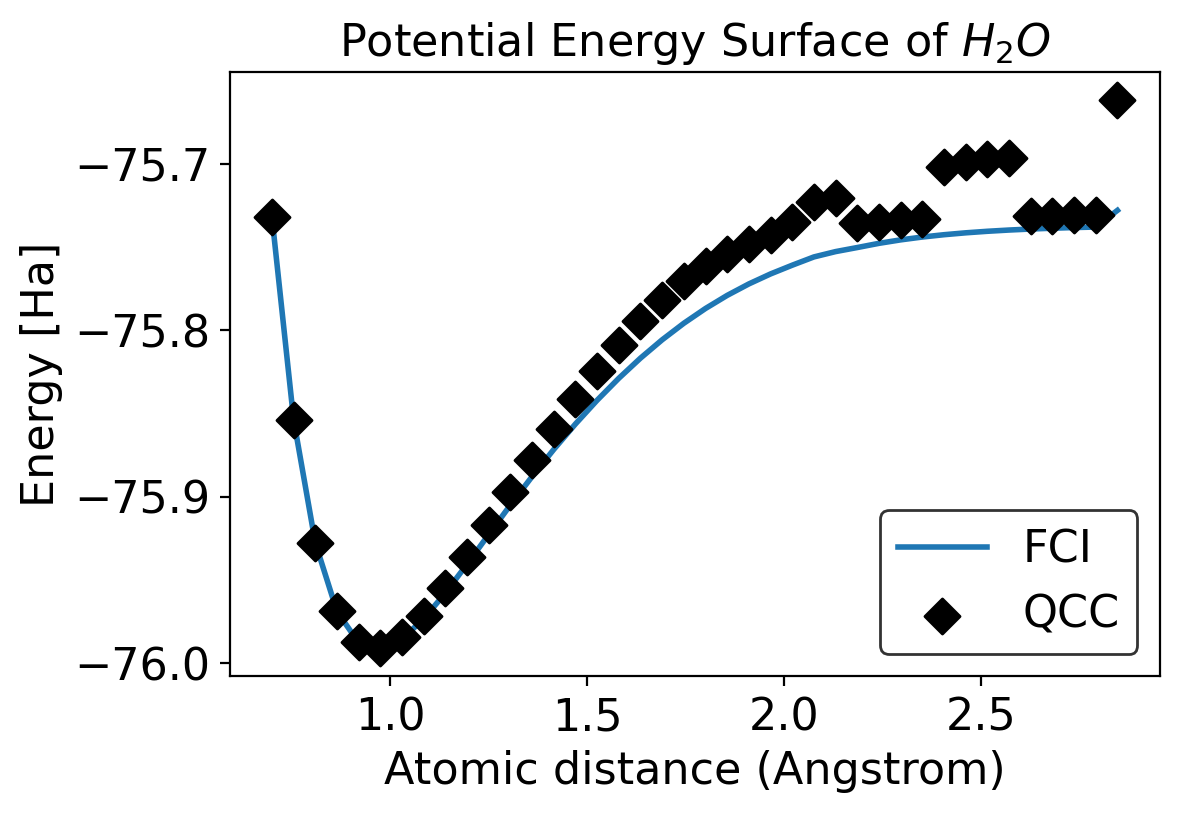

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4), dpi=200)
plt.plot(distances, FCI, label='FCI', linewidth=2, color='tab:blue')
plt.scatter(distances, QCC, label='QCC', s=80, marker='D', color='black', zorder=5)
plt.xlabel('Atomic distance (Angstrom)', fontsize=16)
plt.ylabel('Energy [Ha]', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(labelsize=16)
plt.title(r'Potential Energy Surface of $H_2 O$', fontsize=16)
plt.legend(fontsize=16, loc='best', edgecolor='black')
plt.show()